# Продвинутое машинное обучение: ДЗ №3

In [1]:
import re
from collections import Counter, OrderedDict
from typing import Dict, Set

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
PATH_WAP = "../hw03/data/WarAndPeace.txt"
PATH_AK = "../hw03/data/AnnaKarenina.txt"
PATH_TEST = "../hw03/data/BladeRunner.txt"
PATH_MESSAGE = "../hw03/data/message.txt"

In [9]:
ALPHABET = list(" абвгдежзийклмнопрстуфхцчшщъыьэюя")
REGEXP_ALPHABET = re.compile('[а-я]+')

In [10]:
def get_text(path):
    with open(path, "r") as f:
        text = f.read()
    return text


def process_text(text):
    text = text.lower()
    words = re.findall(REGEXP_ALPHABET, text)
    text = ' '.join(words)
    return text

In [11]:
TEXT_TRAIN = process_text(get_text(PATH_WAP)) + " " + process_text(get_text(PATH_AK))
TEXT_TEST = process_text(get_text(PATH_TEST))
MESSAGE = get_text(PATH_MESSAGE)

In [12]:
def extract_ngrams(text, n=1):
    return [text[i:i + n] for i in range(len(text) - n + 1)]


def calculate_ngram_frequencies(text, n=1):
    processed_text = extract_ngrams(text, n)
    counter = Counter(processed_text)
    n_ngrams = len(processed_text)
    stats = OrderedDict(sorted(counter.most_common(), key=lambda x: x[1]))
    for ngram in stats:
        stats[ngram] /= n_ngrams
    return stats

In [13]:
def generate_cipher_keys():
    cipher_alphabet_codes = np.random.choice(range(9632, 9680), replace=False, size=len(ALPHABET))
    cipher_alphabet = list(map(chr, cipher_alphabet_codes))
    encryption_key = dict(zip(ALPHABET, cipher_alphabet))
    decryption_key = dict(zip(cipher_alphabet, ALPHABET))
    return encryption_key, decryption_key


def encrypt_text(text: str, key: Dict) -> str:
    encrypted_text = text
    for old_char, new_char in key.items():
        encrypted_text = encrypted_text.replace(old_char, new_char)
    return encrypted_text


def make_decryption_key(stats_train: OrderedDict, stats_test: OrderedDict) -> OrderedDict:
    n_grams_train = list(stats_train.keys())
    frequencies_train = list(stats_train.values())
    mapping = {}
    for n_gram_test, frequency_test in stats_test.items():
        index = np.argmin(np.abs(np.array(frequencies_train) - frequency_test))
        mapping[n_gram_test] = n_grams_train[index]
    return mapping


def decrypt_text(text, key):
    text_list = list(text)
    for old_char, new_char in key.items():
        indices = [elem.span()[0] for elem in re.finditer(old_char, text)]
        for index in indices:
            text_list[index:index + len(new_char)] = new_char
    return ''.join(text_list)

## 1. Частотный метод с униграммами

### Получение статистик

In [14]:
unigram_frequencies_train = calculate_ngram_frequencies(TEXT_TRAIN, n=1)

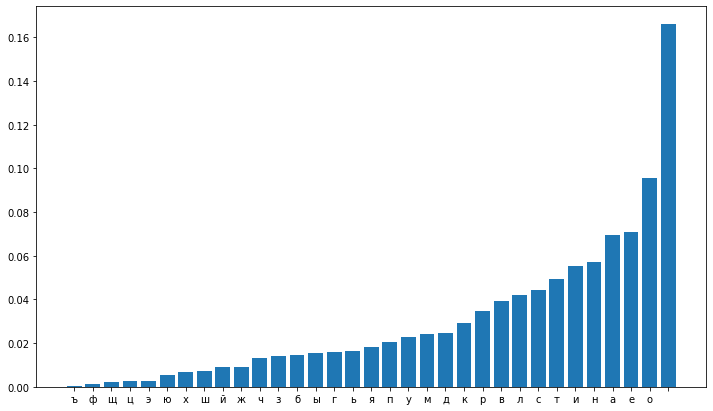

In [15]:
plt.figure(figsize=(12, 7))
plt.bar(unigram_frequencies_train.keys(), unigram_frequencies_train.values())
plt.show()

In [16]:
len(unigram_frequencies_train)

33

### Тестовый текст

In [17]:
np.random.seed(0)

encryption_key, decryption_key = generate_cipher_keys()

In [18]:
encrypted_test_text = encrypt_text(TEXT_TEST, encryption_key)
encrypted_test_text

'◆▽▾▪◅◂◁▽▼▤▿▢◂▽▾▢▽◊▼▢▽▾▥▽◁▮◅▪▽◎▲▢▯▼▢▽●◂▽◎▢▾◂▲▪▼◂▽▨▼▶▲▻▢▾▥◂▽▿▢▲▤►◁▪▽▾▽▢◀●◂▽●▤▽◎▢◅▯▼▶◎▤◉▽▿▽▢▲▪▢●▶▽◆▽▯▻▢▼▲◂◁▽▿▤▿▽▯▪▽◁▶◊▪▽▻◂▲▴▤▮▼▽▾▢▽▼▱▻◂▽►◁▪▧▽▾▲▤▼▽▼▤●◀◂▫▧◂▲▤▽▾▯◂▽◃▼▪▽▻◀●▢▾◂●▪◆▽▪▯◊◂▧●▶▼▽▾▢▽▾▲◂▻◂●▪▽▿▤▿▽▯◁◂▧▥▽◎▢◅▽◅▢◈◅◂▻▽◎▲▪▨◁▢▽▾▲◂▻◆▽▶▻▪▲▤▼▱'

In [19]:
decrypt_text(encrypted_test_text, decryption_key)

'я видел такое во что вы люди просто не поверите штурмовые корабли в огне на подступах к ориону я смотрел как си лучи мерцают во тьме близ врат тангейзера все эти мгновения исчезнут во времени как слезы под дождем пришло время умирать'

In [20]:
unigram_frequencies_test = calculate_ngram_frequencies(encrypted_test_text, n=1)
key_unigram = make_decryption_key(unigram_frequencies_train, unigram_frequencies_test)
decrypt_text(encrypted_test_text, key_unigram)

'ь индор нткео ие чне ич рйдн диекне во деиоинно йндивеичо кеитйрн и ечво вт дедкнддтю к еиневд ь квениор ктк кн рдчн воиютйн ие нйво йрнь иитн нтвчоюьоит ико юнн вчвеиовнь нкчоьвдн ие ииововн ктк кроьч дед деюдов динйре ииовь двнитнй'

Пробел и некоторые буквы определены верно, но смысл в расшифровке не обнаруживается

## 2. Частотный метод с биграммами

In [21]:
BIGRAM_FREQUENCIES_TRAIN = calculate_ngram_frequencies(TEXT_TRAIN, n=2)

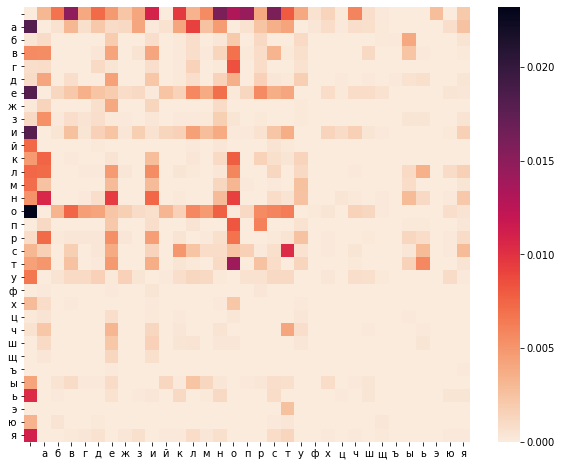

In [22]:
data = np.zeros((33, 33))

for i in range(33):
    for j in range(33):
        ngram = ALPHABET[i] + ALPHABET[j]
        if ngram not in BIGRAM_FREQUENCIES_TRAIN:
            continue
        data[i][j] = BIGRAM_FREQUENCIES_TRAIN[ngram]

plt.figure(figsize=(10, 8))
sns.heatmap(data, xticklabels=ALPHABET, yticklabels=ALPHABET, cmap=sns.cm.rocket_r)
plt.yticks(rotation=0)
plt.show()

In [23]:
len(BIGRAM_FREQUENCIES_TRAIN), 33 ** 2

(819, 1089)

### Тестовый текст

In [24]:
bigram_frequencies_test = calculate_ngram_frequencies(encrypted_test_text, n=2)
key_bigram = make_decryption_key(BIGRAM_FREQUENCIES_TRAIN, bigram_frequencies_test)
decrypt_text(encrypted_test_text, key_bigram)

'ео аггг о оооо о агоо ггоаао  оагоо го   о  оао агоаг ооо  ге ггоо гогоо ого ооггоааае оо оагоае огоа оге    оо оаао  ооааа о о оо о ггоао е  оооааааа е о ао аао ого оггое ааагого о оо о оого     оагого ооааааг оо  оааоо о ое ааае оо'

Получилось гораздо хуже, чем в случае использования униграмм. По-видимому, это объясняется тем, что у короткого текста вероятность коллизий n-грамм выше. Также длина отрывка влияет на точность подсчета частот.

Обучимся на тренировочном тексте для исключения ошибки имплементации алгоритма

In [25]:
encrypted_train_text = encrypt_text(TEXT_TRAIN, encryption_key)
encrypted_train_text[:200]

'▾▢▫●▤▽▪▽▻▪▲▽▯▤▻▥▫▽▪▧▾◂▯▼●▥▫▽▲▢▻▤●▽◁▱▾▤▽●▪▿▢◁▤◂▾▪◊▤▽▼▢◁▯▼▢◀▢▽▿▤▿▽●▪▿▤▿▢◂▽◅▲▶◀▢◂▽◎▲▢▪▧▾◂◅◂●▪◂▽◎▪▯▤▼◂◁◆▽▢▼▲▤◈▤◂▼▽◀◁▶►▪●▶▽◂◀▢▽▻▪▲▢▢▭▶▭◂●▪◆▽▪▽▰▪◁▢▯▢▰▪▪▽◃▼▤▽▿●▪◀▤▽▪▧▽▲▤▧▲◆◅▤▽▾◂◊●▥◉▽◎▢▼▢▻▶▽◊▼▢▽▢●▤▽▢►▢▽▾▯◂▻▽▢'

In [26]:
bigram_frequencies_train_encrypted = calculate_ngram_frequencies(encrypted_train_text, n=2)
key_bigram_train = make_decryption_key(BIGRAM_FREQUENCIES_TRAIN, bigram_frequencies_train_encrypted)

In [27]:
decrypt_text(encrypted_train_text[:200], key_bigram_train)

'война и мир самый известный роман льва николаевича толстого как никакое другое произведение писателя отлажает глубину его мироощущения и философии эта книга из лазряда вечных потому что она обо всем о'

Текст восстановлен за иключением нескольких мест: "отлажает", "лазряда"

## 3. MCMC с биграммами

In [28]:
MIN_PROB = 1e-8


def calculate_log_likelihood(decrypted_text, ngram_frequencies):
    """Логарифм правдоподобия расшифрованного сообщения на основе частот n-грамм"""
    n = len(list(ngram_frequencies.keys())[0])
    processed_text = extract_ngrams(decrypted_text, n=n)
    score = 0
    for ngram in processed_text:
        if ngram not in ngram_frequencies:
            score += np.log(MIN_PROB)
        else:
            score += np.log(ngram_frequencies[ngram])
    return -score


def random_swap(key):
    """Случайным образом меняет местами два символа в ключе расшифровки"""
    char_1, char_2 = np.random.choice(list(key.keys()), replace=False, size=2)
    key[char_1], key[char_2] = key[char_2], key[char_1]
    

def random_add(key, char):
    """Добавляет случайный символ из алфавита языка, если алфавит зашифрованного сообщений неполный"""
    key[np.random.choice(list(key.keys()))] = char
    
    
def generate_decryption_key(text: str) -> Dict:
    text_alphabet = sorted(set(text))
    values = np.random.choice(ALPHABET, replace=False, size=len(text_alphabet))
    decryption_key = dict(zip(text_alphabet, values))
    return decryption_key


def propose_decryption_key(key):
    """Предложение нового ключа расшифровки с одним случайным отличием от текущего"""
    proposed_key = key.copy()
    char = np.random.choice(ALPHABET)
    if char not in proposed_key.values():
        random_add(proposed_key, char)
    else:
        random_swap(proposed_key)
    return proposed_key


def main_algorithm(encrypted_text, ngram_frequencies, n_iters=10 ** 5):
    
    key_cur = generate_decryption_key(encrypted_text)
    print("Начальный ключ расшифровки:")
    print(key_cur)
    print()
    
    for i in range(n_iters + 1):
        
        key_new = propose_decryption_key(key_cur)
        
        decrypted_text_cur = decrypt_text(encrypted_text, key_cur)
        decrypted_text_new = decrypt_text(encrypted_text, key_new)

        score_cur = calculate_log_likelihood(decrypted_text_cur, ngram_frequencies)
        score_new = calculate_log_likelihood(decrypted_text_new, ngram_frequencies)

        # если предложенный ключ дешифрует лучше текущего, принимаем его
        if score_new < score_cur:
            key_cur = key_new
        # иначе принимаем с вычисленной вероятностью
        else:
            p = np.exp(score_cur - score_new)
            p = np.minimum(1, p)
            if np.random.rand() < p:
                key_cur = key_new

        if i % (n_iters // 4) == 0: 
            print(f"Log likelihood: {score_cur:.2f}")
            print(decrypt_text(encrypted_text, key_cur))
            print()

### Тестовый пример

In [29]:
np.random.seed(2079)

N_ITERS = 10 ** 4 * 4

main_algorithm(encrypted_test_text, BIGRAM_FREQUENCIES_TRAIN, n_iters=N_ITERS)

Начальный ключ расшифровки:
{'▢': 'й', '▤': 'ф', '▥': 'л', '▧': 'я', '▨': 'г', '▪': 'х', '▫': 'д', '▮': 'б', '▯': 'ь', '▱': 'ш', '▲': 'и', '▴': 'ц', '▶': 'т', '►': 'м', '▻': 'в', '▼': 'е', '▽': 'ы', '▾': 'ъ', '▿': 'ч', '◀': 'ю', '◁': 'з', '◂': 'у', '◃': 'с', '◅': ' ', '◆': 'к', '◈': 'р', '◉': 'о', '◊': 'а', '◎': 'п', '●': 'ж'}

Log likelihood: 2958.32
кыъх узыефчйуыъйытейыълызб хыпийьейыжуыпйъуихеуыгеаивйълуычйифмзхыъыйюжуыжфыпй ьеапфоычыйихйжаыкыьвйеиузычфчыьхызатхывуицфбеыъйыешвуымзхяыъифеыефжюудяуифыъьуысехывюжйъужхкыхьтуяжаеыъйыъиувужхычфчыьзуялыпй ы йр увыпихгзйыъиувкыавхифеш

Log likelihood: 1312.90
я дибел накое до шно дь лжби провно те подерине знурмодье корагли д очте та побвнупаф к ориоту я вмонрел как ви луши мерцажн до ныме глис дран натчейсера две хни мчтодетия ившестун до дремети как влесь поб боюбем призло дремя умираны

Log likelihood: 1295.92
я видел такое во что вы люди просто не поверите штурмовые корагли в ощне на подступай к ориону я смотрел как си лучи мерхают во 

Лучший результат получился при лоссе 1295.92, хотя он и не минимальный.

Посмотрим, какой лосс у незашифрованного текста:

In [30]:
calculate_log_likelihood(TEXT_TEST, BIGRAM_FREQUENCIES_TRAIN)

1295.8645664956898

Он очень близок к лоссу лучшего результата и тоже больше минимального полученного при обучении.

### Расшифровка сообщения

In [37]:
np.random.seed(2001)

N_ITERS = 10 ** 4 * 4

main_algorithm(MESSAGE, BIGRAM_FREQUENCIES_TRAIN, n_iters=N_ITERS)

Начальный ключ расшифровки:
{'←': 'о', '↘': 'в', '↙': 'с', '↝': 'т', '↞': 'ш', '↟': 'б', '↤': 'х', '↨': 'у', '↲': 'ц', '↳': 'ы', '↷': 'м', '↹': 'н', '↾': 'р', '⇆': 'ъ', '⇈': 'ч', '⇊': 'и', '⇌': 'з', '⇏': 'ж', '⇒': 'ф', '⇙': 'л', '⇛': 'к', '⇞': 'ю', '⇠': 'й', '⇯': 'я', '⇰': 'а', '⇴': 'ь', '⇷': 'д', '⇸': 'э'}

Log likelihood: 2403.95
ойфбнминмбхбуонткяыьфчтирнбфбндкюубнткяыьфчтирнуозйунлнэукскнйккцжотбшнзкукяирнфосзкндякюбуьучнйзкяоонмйоскнминмйонйхофьфбндяьмбфчткнбндкфлюбуоныьзйбыьфчтирнцьффнаьндкйфохтоонюоумояуконаьхьтбонзляйьнвкушнзктоюткншнтбюоскнтонкцожьъ

Log likelihood: 1244.70
если вы вимите норжальный или подти норжальный текст у этого соочшения который легко продитать скорее всего вы все смелали правильно и полудите жаксижальный чалл за послемнее детвертое замание курса ботя конедно я нидего не очешац

Log likelihood: 1248.54
если вы видите норжальный или почти норжальный текст у этого сообмения который легко прочитать скорее всего вы все сделали правильно и получите жаксижальн

Лучший вариант оказался при лоссе 1248.54.

In [31]:
decrypted_message = "если вы видите нормальный или почти нормальный \
текст у этого сообщения который легко прочитать скорее всего вы все \
сделали правильно и получите максимальный балл за последнее четвертое \
задание курса хотя конечно я ничего не обещаю"

In [32]:
calculate_log_likelihood(decrypted_message, BIGRAM_FREQUENCIES_TRAIN)

1246.4751851563594

Реальный лосс оказался опять близок к лоссу лучшего результата и опять выше минимального полученного

## 4. MCMC с триграммами

In [33]:
TRIGRAM_FREQUENCIES_TRAIN = calculate_ngram_frequencies(TEXT_TRAIN, n=3)

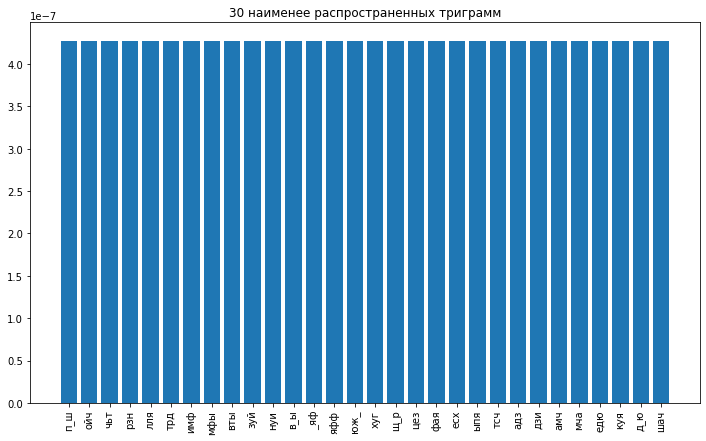

In [34]:
n_trigrams = 30

plt.figure(figsize=(12, 7))
plt.bar(
    [ngram.replace(' ', '_') for ngram in list(TRIGRAM_FREQUENCIES_TRAIN.keys())[:n_trigrams]], 
    list(TRIGRAM_FREQUENCIES_TRAIN.values())[:n_trigrams],
)
plt.title(label=f"{n_trigrams} наименее распространенных триграмм")
plt.xticks(rotation=90)
plt.show()

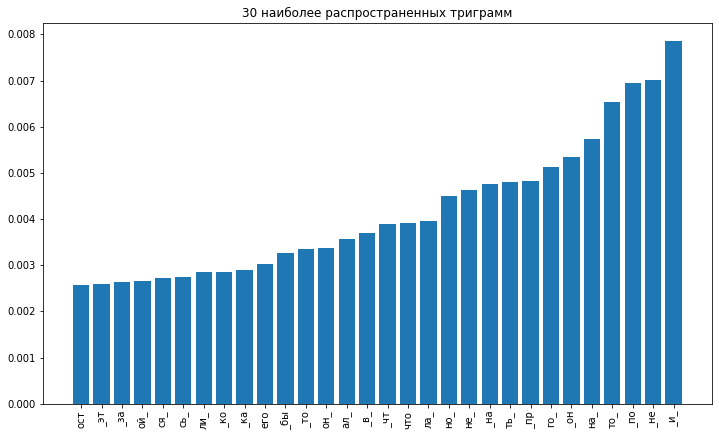

In [35]:
plt.figure(figsize=(12, 7))
plt.bar(
    [ngram.replace(' ', '_') for ngram in list(TRIGRAM_FREQUENCIES_TRAIN.keys())[-n_trigrams:]], 
    list(TRIGRAM_FREQUENCIES_TRAIN.values())[-n_trigrams:],
)
plt.title(label=f"{n_trigrams} наиболее распространенных триграмм")
plt.xticks(rotation=90)
plt.show()

### Тестовый пример

In [51]:
np.random.seed(0)

N_ITERS = 10 ** 4

main_algorithm(encrypted_test_text, TRIGRAM_FREQUENCIES_TRAIN, n_iters=N_ITERS)

Начальный ключ расшифровки:
{'▢': 'к', '▤': 'у', '▥': 'ч', '▧': 'р', '▨': 'б', '▪': 'ш', '▫': 'щ', '▮': 'п', '▯': 'й', '▱': 'я', '▲': 'ь', '▴': 'ц', '▶': 'о', '►': 'з', '▻': 'м', '▼': 'э', '▽': 'д', '▾': 'н', '▿': 'ы', '◀': 'х', '◁': 'а', '◂': 'л', '◃': 'е', '◅': 'г', '◆': 'с', '◈': 'ф', '◉': 'т', '◊': 'и', '◎': 'ж', '●': 'ю'}

Log likelihood: 4041.65
сдншгладэуыклднкдиэкднчдапгшдоькйэкдюлдокнльшэлдбэжьмкнчлдыкьузашдндкхюлдюудокгйэжоутдыдкьшкюждсдймкэьладыуыдйшдажишдмльцупэднкдэямлдзашрдньуэдэуюхлщрльуднйлдеэшдмхюкнлюшсдшйилрюжэднкдньлмлюшдыуыдйалрчдокгдгкфглмдоьшбакдньлмсджмшьуэя

Log likelihood: 2063.99
я вичем лакое во шло вь мычи гносло ре говениле злунтовье конахми в опре ра гочслугаж к ониору я столнем как си муши тенцаыл во лбте хмид внал ларпейдена все эли тпроверия исшедрул во внетери как смедь гоч чоючет гнизмо внетя утиналб

Log likelihood: 1849.67
я видел такое во что вь люди просто не поверите хтурмовье коразли в огне на подступац к ориону я смотрел как си лучи мербают во 

Результат получился идеальным, хотя и пришлось немного поэкспериментировать с random seed. Потребовалось меньше итераций.

### Расшифровка сообщения

In [32]:
np.random.seed(2001)

N_ITERS = 10 ** 4

main_algorithm(MESSAGE, TRIGRAM_FREQUENCIES_TRAIN, n_iters=N_ITERS)

Начальный ключ расшифровки:
{'←': 'о', '↘': 'в', '↙': 'с', '↝': 'т', '↞': 'ш', '↟': 'б', '↤': 'х', '↨': 'у', '↲': 'ц', '↳': 'ы', '↷': 'м', '↹': 'н', '↾': 'р', '⇆': 'ъ', '⇈': 'ч', '⇊': 'и', '⇌': 'з', '⇏': 'ж', '⇒': 'ф', '⇙': 'л', '⇛': 'к', '⇞': 'ю', '⇠': 'й', '⇯': 'я', '⇰': 'а', '⇴': 'ь', '⇷': 'д', '⇸': 'э'}

Log likelihood: 3699.39
ойфбнминмбхбуонткяыьфчтирнбфбндкюубнткяыьфчтирнуозйунлнэукскнйккцжотбшнзкукяирнфосзкндякюбуьучнйзкяоонмйоскнминмйонйхофьфбндяьмбфчткнбндкфлюбуоныьзйбыьфчтирнцьффнаьндкйфохтоонюоумояуконаьхьтбонзляйьнвкушнзктоюткншнтбюоскнтонкцожьъ

Log likelihood: 1794.97
если вы вимите норбальный или почти норбальный текст у штого сооджения который легко прочитать скорее всего вы все смелали правильно и получите баксибальный далл за послемнее четвертое замание курса эотя конечно я ничего не одежах

Log likelihood: 1738.60
если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальн

Результат получился идеальным. Потребовалось меньше итераций.